## Experiment to determine Frequency for running Model 

Author : Sai Siddartha Maram


Contact: msaisiddartha1@gmail.com | smaram_be16@thapar.edu

### Objectives
1. Run detection at Camera FPS, in our case the camera FPS is 30FPS, to start of I will run detection on every 30th image.
2. Log all the bounding boxes and classes of objects detected
3. Develop a certain metric in terms of centers of bounding boxes, classes detected to determine if the two scenes are different
4. Try delta methods and see if they match


In [2]:


%load_ext Cython
import cv2
import numpy as np
import argparse
import time
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils

from scipy.spatial import distance as dist
import numpy as np

from skimage.measure import compare_ssim
from PIL import Image
import time

import scipy
import random

import tensorflow as tf
import math

# Image manipulation.
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
import inception5h
model = inception5h.Inception5h()

import imagehash
# My Packages
import constants
import helper



Instructions for updating:
Use tf.gfile.GFile.



Loading Model : YOLOV3

In [3]:
options = constants.options_v3
np.random.seed(42)
LABELS = open(options['labelsPath']).read().strip().split("\n")
color = (255, 0, 0)
inception5h.maybe_download()

Data has apparently already been downloaded and unpacked.


1. Load the darknet model using readNetFromDarkent(), feel free to try other DL models
2.  In CV2.dnn you load a model and then forward propgate the image for prediction, 
    the forwad function expects you give the layer till which you want the image to be 
    propgated, in our case since we want the final result, we want the image to be 
    propgated till the last layer. The .getLayerNames() gives the list of all layers.
    From here to identify the last layer, we need to get last unconnected layer, the 
    unconnected layers can be found by .getUnconnectedOutLayers().
3. blob, the cv.dnn does not take a raw image, instead takes a blob, A blob is an image which 
   is modified and smoothed as per the network requirments. For Ex. 
   YOLO takes in an image only of the size 416 x 416 (single channel)
   hence we reduce each color from [0-255] to [0-1] and image size (416,416)

In [4]:
def predict_object(image_path,net):
    start = time.time()
    image = cv2.imread(image_path)
    #image=cv2.resize(image,(416,416))
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(
        image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerOutputs = net.forward(ln)
    

    # show timing information on YOLO
    

    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > options['confidence']:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, options['confidence'], options['threshold'])
    
    detections=[]
    if len(idxs) > 0:
        for i in idxs.flatten():
            temp_list=[]
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            plt.imshow(image)

            temp_list.append(x)
            temp_list.append(y)
            temp_list.append(w)
            temp_list.append(h)
            temp_list.append(LABELS[classIDs[i]])
            temp_list.append(confidences[i])
            detections.append(temp_list)
            
    print('Time Taken', time.time()-start)   
    return detections

In [5]:
def predict_image(image,net):
    start = time.time()
    #image = cv2.imread(image_path)
    #image=cv2.resize(image,(416,416))
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(
        image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerOutputs = net.forward(ln)
    

    # show timing information on YOLO
    

    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > options['confidence']:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, options['confidence'], options['threshold'])
    
    detections=[]
    if len(idxs) > 0:
        for i in idxs.flatten():
            temp_list=[]
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            plt.imshow(image)

            temp_list.append(x)
            temp_list.append(y)
            temp_list.append(w)
            temp_list.append(h)
            temp_list.append(LABELS[classIDs[i]])
            temp_list.append(confidences[i])
            detections.append(temp_list)
            
    print('Time Taken', time.time()-start)   
    return detections

In [6]:
net = cv2.dnn.readNetFromDarknet(options['model'], options['load'])

Time Taken 0.9468793869018555
Number of Detections: 4
[363, 692, 57, 246, 'person', 0.8407601714134216]
[1559, 87, 86, 92, 'car', 0.7853524684906006]
[360, 702, 56, 154, 'person', 0.6280760765075684]
[498, 752, 70, 208, 'person', 0.548801839351654]


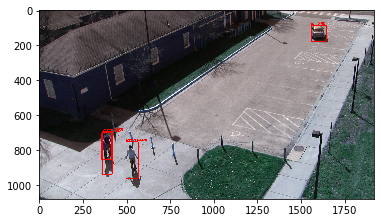

In [7]:
detections=predict_object('testing_images/4561.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')


Time Taken 1.2213554382324219
Number of Detections: 7
[1168, 444, 311, 161, 'car', 0.9971790313720703]
[1238, 335, 44, 110, 'person', 0.9966909289360046]
[1664, 357, 40, 96, 'person', 0.986341655254364]
[1613, 386, 47, 116, 'person', 0.9570065140724182]
[1712, 387, 39, 88, 'person', 0.8744476437568665]
[1373, 69, 43, 80, 'person', 0.7361916303634644]
[1373, 72, 27, 50, 'person', 0.6172140836715698]


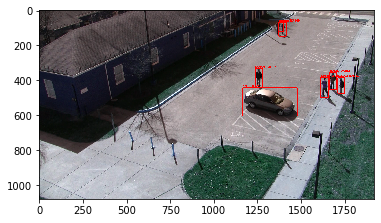

In [8]:
detections=predict_object('testing_images/16892.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')


Time Taken 1.039482831954956
Number of Detections: 7
[1168, 444, 311, 161, 'car', 0.9971790313720703]
[1238, 335, 44, 110, 'person', 0.9966909289360046]
[1664, 357, 40, 96, 'person', 0.986341655254364]
[1613, 386, 47, 116, 'person', 0.9570065140724182]
[1712, 387, 39, 88, 'person', 0.8744476437568665]
[1373, 69, 43, 80, 'person', 0.7361916303634644]
[1373, 72, 27, 50, 'person', 0.6172140836715698]


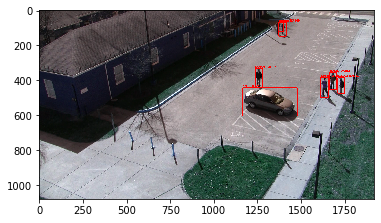

In [9]:
detections=predict_object('testing_images/16892.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')

In [10]:
def image_subtraction(path_image1,path_image2):
    img1 = cv2.imread(path_image1)
    img2 = cv2.imread(path_image2)


    start_time=time.time()
    grayA = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    (score, grad,diff) = compare_ssim(grayA, grayB, full=True,gradient=True)
    #value ranges between -1 to 1. 1 indicates a perfect match
    print('Time Taken for execution',time.time()-start_time)
    print("SSIM: {}".format(score))
    


In [11]:
image_subtraction('testing_images/4561.jpg','testing_images/16892.jpg')

Time Taken for execution 0.5166854858398438
SSIM: 0.837833208292906


In [12]:
def histogram_matching(path_image1, path_image2):
    img1 = cv2.imread(path_image1)
    img2 = cv2.imread(path_image2)
#     plt.hist(img1.ravel(),256,[0,256])
#     plt.show()
#     plt.hist(img2.ravel(),256,[0,256])
#     plt.show()

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    start_time=time.time()

    hist1 = cv2.calcHist(img1, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()

    hist2 = cv2.calcHist(img2, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.normalize(hist2, hist2).flatten()

    #a = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT) ----> WASTE!
    #a = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL) ----->Waste!
    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    print('[INFO]Time for Histogram Mapping',time.time()-start_time)

    return chi_square


In [13]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/4561.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.0009434223175048828
CHI Square value 0.0


In [14]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/16892.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.000957489013671875
CHI Square value 0.07969235225853039


In [15]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/2.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.0017189979553222656
CHI Square value 0.16284510427246612


### Learnable Encryption

In [16]:
img=cv2.imread('testing_images/16892.jpg')
print(img.shape)

(1080, 1920, 3)


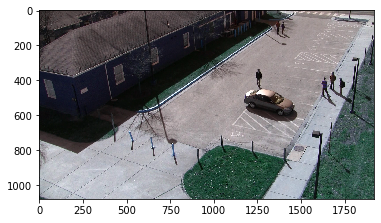

In [17]:
N=8
M=8
plt.imshow(img)

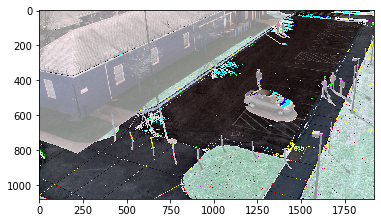

In [18]:
# b=[]
# for x in range(0,img.shape[0],M):
#     for y in range(0,img.shape[1],N):
#         b.append(img[x:x+M,y:y+N])
# print(len(b))

blank_image = np. zeros(shape=[1080,1920, 3], dtype=np. uint8)

for x in range(0,img.shape[0],M):
    for y in range(0,img.shape[1],N):
        blank_image[x:x+M,y:y+N]=img[x:x+M,y:y+N]+129

cv2.imshow('img',blank_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(blank_image)

Time Taken 0.6957454681396484
Number of Detections: 1
[1174, 457, 298, 177, 'car', 0.8104709386825562]


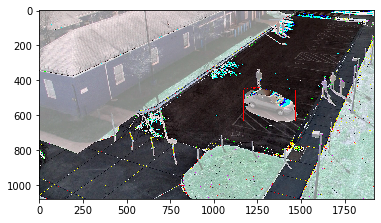

In [19]:
detections=predict_image(blank_image,net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')


### DREAM:Cryption

<b>Function</b> : generate_new_look_up_table_random(@param1,@param2)

<b>Param</b> : color_channel, chunk size

<b>Objective</b>:
generate_new_look_up_table_random(R,n): this takes in 1 dimension color channel and shuffles it all in chunks of 8 

In [20]:
def generate_new_look_up_table_random(R,n):
    R_new=[R[i:i + n] for i in range(0, len(R), n)]
    res = random.sample(R_new, len(R_new)) 
    R_prime=[]
    for i in res:
        for j in i:
            R_prime.append(j)
 
    return R_prime

<b>Function</b>: lut_generator(@param)

<b>Param</b> : chunksize

<b>Objective</b>: takes in a chunk size and gives out a look up table with random shuffling for each of the color channels
    

In [21]:
def lut_generator(n):
    lut = np.zeros((256, 1, 3), dtype=np.uint8)
    lut[:, 0, 0] = generate_new_look_up_table_random([i for i in range(0,256)],n)
    lut[:, 0, 1] = generate_new_look_up_table_random([i for i in range(0,256)],n)
    lut[:, 0, 2] = generate_new_look_up_table_random([i for i in range(0,256)],n)
    return lut

<b>Function</b>: encrypt(@param1,@param2)

<b>Param</b> : image_to_encrypt,look_up_table (key)

<b>Objective</b>: Gives out an encrypted image    

In [32]:
def encrypt(image,lut):
    im_color = cv2.LUT(image,lut)
    return im_color
    

In [50]:
%%cython -a
cimport numpy


#@cython.boundscheck(False)
cpdef unsigned char[:,:, :] decrypt(numpy.ndarray lut, unsigned char [:,:,:] im_encoded):
    # set the variable extension types
    cdef int i, j, w, h
    cdef list R = lut[:,0,0].tolist()
    cdef list G = lut[:,0,1].tolist()
    cdef list B = lut[:,0,2].tolist()
    
    h = im_encoded.shape[0]
    w = im_encoded.shape[1]

    for i in range(0, h):
        for j in range(0, w):
            im_encoded[i][j][0]=R.index(im_encoded[i][j][0])
            im_encoded[i][j][1]=G.index(im_encoded[i][j][1])
            im_encoded[i][j][2]=B.index(im_encoded[i][j][2])

    return im_encoded

In [56]:
image_to_encrypt=cv2.imread('testing_images/people.jpg')

cv2.imshow('image_to_enc',image_to_encrypt)
cv2.waitKey(0)
cv2.destroyAllWindows()

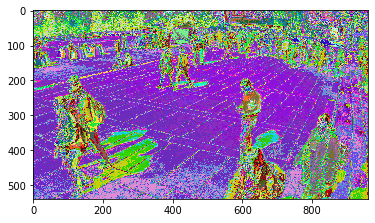

In [57]:
lut = lut_generator(8)

encrypted_image = encrypt(image_to_encrypt, lut )
cv2.imwrite('encrypted.jpg',encrypted_image)
plt.imshow(encrypted_image)

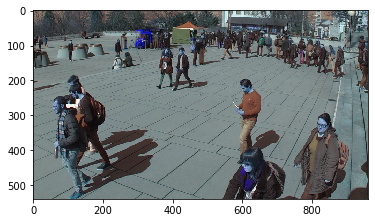

In [58]:
dec=decrypt(lut,encrypted_image)
dec = np.asarray(dec)



cv2.imwrite('decrypted.jpg',dec)
plt.imshow(dec)

Time Taken 1.0775012969970703
Number of Detections: 36
[397, 106, 62, 123, 'person', 0.9974473118782043]
[577, 189, 75, 229, 'person', 0.9973427057266235]
[59, 242, 88, 295, 'person', 0.9940976500511169]
[358, 101, 43, 120, 'person', 0.9784651398658752]
[460, 72, 35, 87, 'person', 0.9679273962974548]
[744, 304, 163, 231, 'person', 0.9669762253761292]
[256, 119, 31, 43, 'person', 0.9668591618537903]
[508, 387, 232, 152, 'person', 0.9515177607536316]
[234, 82, 18, 53, 'person', 0.9508533477783203]
[105, 195, 105, 262, 'person', 0.9362936019897461]
[227, 126, 29, 44, 'person', 0.9343949556350708]
[540, 71, 34, 69, 'person', 0.9299918413162231]
[849, 102, 41, 90, 'person', 0.9130941033363342]
[925, 88, 31, 136, 'person', 0.9067389965057373]
[726, 293, 210, 251, 'person', 0.9026826620101929]
[759, 74, 24, 89, 'person', 0.8571439385414124]
[807, 92, 37, 86, 'person', 0.8029420971870422]
[692, 73, 26, 68, 'person', 0.7925848960876465]
[528, 388, 175, 152, 'person', 0.7533063888549805]
[642, 6

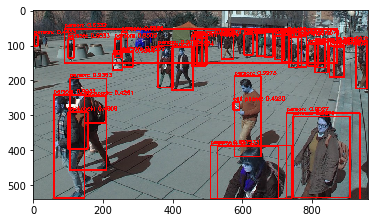

In [59]:
detections=predict_object('decrypted.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')

Time Taken 0.5443735122680664
Number of Detections: 5
[406, 99, 56, 126, 'person', 0.9116936922073364]
[66, 189, 144, 304, 'person', 0.8719995617866516]
[46, 181, 182, 324, 'person', 0.8590452075004578]
[259, 119, 25, 45, 'person', 0.7315008044242859]
[359, 94, 42, 131, 'person', 0.5273060202598572]


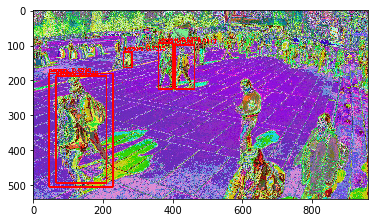

In [60]:
detections=predict_object('encrypted.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')

### Detection Performance and Evaluation Based on Image Sizes

In [ ]:
def multi_shape_detection(image_path,net):
    img=cv2.imread(image_path)
    
    h,w,_=img.shape
    #half
    print(img.shape)
    img_1 = cv2.resize(img,(w//2,h//2))
    print(img_1.shape)
    #one fourth
    img_2 = cv2.resize(img_1,(w//4,h//4))
    print(img_2.shape)
    detections = predict_image(img,net)
    detection_half = predict_image(img_1,net)
    detection_quarter = predict_image(img_2,net)
    
    return detections,detection_half,detection_quarter

In [ ]:
image_path='testing_images/16892.jpg' 
detections,detection_half,detections_quarter = multi_shape_detection(image_path,net)
# print('Number of Detections in full image:', len(detections))
# print(*detections,sep='\n')

In [ ]:
print('Number of Detections in half size:', len(detection_half))
print(*detection_half,sep='\n')

In [ ]:
print('Number of Detections in quarter size:', len(detections_quarter))
print(*detections_quarter,sep='\n')